# Data Storytelling

#### Questions Asked:
1. For the patents granted in 2017, how are US-applicants distributed across the country?
2. For the patents granted in 2017, how are the filing dates distributed?
3. For the patents granted in 2017, are there any patterns in number of filings per day?
3. What metadata factors influence patent prosecution time?
4. Is there a way to predict prosecution time based purely on bibliographic data?

#### Trends Investigated:
1. Correlation between number of claims and prosecution period.
2. Correlation between number of figures and prosecution period.
3. Correlation between "figure density" (i.e., number of figures per sheet) and prosecution period.


### Imports, Loading and Data Munging

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#read in intermediate csv file generated by data wrangling notebook
all_patents_df = pd.read_csv('../intermediate_csv_files/clean_raw_data.csv', parse_dates=['filing_date','grant_date'])

# get rid of "extra index" column from the csv file
del all_patents_df['Unnamed: 0'] 

all_patents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352567 entries, 0 to 352566
Data columns (total 12 columns):
application_number          352567 non-null int64
application_type            352567 non-null object
city                        352567 non-null object
country                     352567 non-null object
filing_date                 352567 non-null datetime64[ns]
grant_date                  352567 non-null datetime64[ns]
invention_title             352567 non-null object
number-of-drawing-sheets    352567 non-null int64
number-of-figures           352567 non-null int64
number_of_claims            352567 non-null int64
patent_number               352567 non-null object
state                       352567 non-null object
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 32.3+ MB


### Time Series Exploration

#### Creation of datetime indexed DataFrame

In [8]:
# create DataFrame with a sorted datetime index 
filing_ts_df = pd.DataFrame(all_patents_df.filing_date.value_counts()).sort_index()

# change column name to 'filings'
filing_ts_df = filing_ts_df.rename(columns={'filing_date':'filings'})

# add running total column and calculate cumulative sum of filings
filing_ts_df['running_total'] = filing_ts_df.filings.cumsum()

filing_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4203 entries, 1986-01-22 to 2017-10-09
Data columns (total 2 columns):
filings          4203 non-null int64
running_total    4203 non-null int64
dtypes: int64(2)
memory usage: 98.5 KB


#### Visualizing time series data

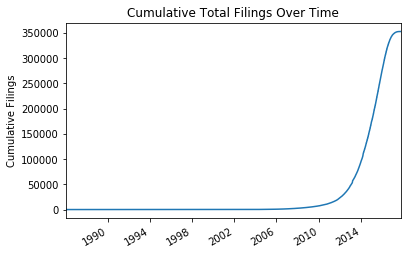

In [9]:
filing_ts_df.running_total.plot()
plt.title("Cumulative Total Filings Over Time")
plt.ylabel("Cumulative Filings")

plt.show()

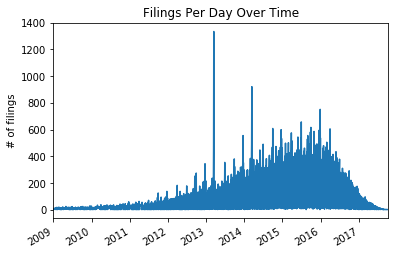

In [12]:
filing_ts_df.filings['2009':].plot()
plt.title("Filings Per Day Over Time")
plt.ylabel("# of filings")

plt.show()

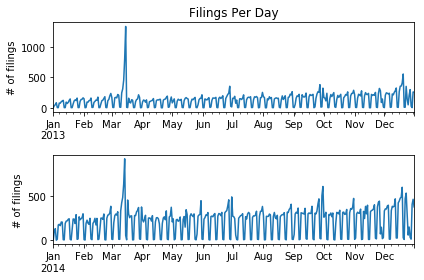

In [14]:
plt.subplot(2,1,1)
filing_ts_df["2013"].filings.plot()
plt.title("Filings Per Day")
plt.ylabel("# of filings")

plt.subplot(2,1,2)
filing_ts_df["2014"].filings.plot()
plt.ylabel("# of filings")

plt.tight_layout()

plt.show()

### Time Series Conclusions

The distribution of filing dates over time is heavily left skewed due to a very small number of extremely old filing dates.  For that reason, the subsequent plots focus only on patents with a filing date in 2010 or later.

The number of filings per day is distributed normally around the expected filing date given all patents in the sample were granted in 2017 (i.e., see below for median prosecution period of 950 days for utility patents).

Interestingly, there is a significant spike observed in 2013 and 2014 at the same time (i.e., mid-March). Furthermore, the subplots focusing on 2013 and 2014 show a similar distribution trend of filing activity with several smaller yet noticeable spikes in activity: late June, late September/early October and late December.  

Additional research is necessary to determine the cause of these daily filing activity patterns from year to year.

### Example Summary Stats (number of claims)

In [ ]:
all_patents_df.number_of_claims.describe()

### Selecting Utility Patents

For the purpose of the deep dive analysis, this project will focus on utility patent types and exclude plant patents, design patents, and reissue patents.  From a domain experience perspective, utility patents have more variation in the number of claims and subject matter covered.  Plant patents and design patents are very different from utility patents but the legal distinction is beyond the scope of this project.  

In [ ]:
utility_patents_df = all_patents_df[all_patents_df.application_type == 'utility']

utility_patents_df.info()

In [ ]:
utility_patents_df.number_of_claims.describe()

## Dealing with Number of Claims Outliers

From the summary statistics on number of claims across the entire set, we see that the median number of claims is 17, while the maximum is 381.  This indicates that the distribution will be skewed to the right.  When reviewing the data, this observation can be seen by looking at the `.value_counts()` for each distinct value in the `number_of_claims` column. From industry experience, one would understand that most utility patent applications have less than 50 claims.  So, in order to create a better distribution, we will narrow down this data set by removing those patents with a number of claims that is greater than 3 standard deviations from the median value.

In [ ]:
claims_std_dev = utility_patents_df.number_of_claims.std()
claims_median = utility_patents_df.number_of_claims.median()

utility_patents_subset_df = utility_patents_df[utility_patents_df.number_of_claims <= (claims_median + 3*claims_std_dev)].copy()

In [ ]:
utility_patents_subset_df.info()

In [ ]:
sns.set(color_codes=True)

sns.distplot(utility_patents_subset_df.number_of_claims, bins=40, kde=False)

plt.show()

In [ ]:
sns.kdeplot(utility_patents_subset_df.number_of_claims, shade=True)

plt.show()

# Calculating Prosecution Period

The time period during which a patent application is being "prosecuted" begins with the filing date and ends with the grant date.

In [ ]:
# create new column 'prosecution_period' as difference between grant date and filing date

utility_patents_subset_df['prosecution_period'] = utility_patents_subset_df.grant_date - utility_patents_subset_df.filing_date

utility_patents_subset_df.info()

In [ ]:
utility_patents_subset_df.prosecution_period = utility_patents_subset_df.prosecution_period.apply(lambda x: x.days)
utility_patents_subset_df.prosecution_period.describe()

In [ ]:
sns.distplot(utility_patents_subset_df.prosecution_period)

plt.show()

## Dealing with Prosecution Period Outliers

Based on the above histogram with KDE plot, we can see that the prosecution period is skewed by a long tail on the right side.  Similar to the narrowing of the data set that we performed for the `number_of_claims` column, we will filter out all of the values that are greater than 3 standard deviations from the median value.

In [ ]:
pros_std_dev = utility_patents_subset_df.prosecution_period.std()
pros_median = utility_patents_subset_df.prosecution_period.median()

utility_patents_subset_df = utility_patents_subset_df[utility_patents_subset_df.prosecution_period <= (pros_median + 3*pros_std_dev)]

sns.distplot(utility_patents_subset_df.prosecution_period)

plt.show()

In [ ]:
sns.jointplot(x='number_of_claims', y='prosecution_period', data=utility_patents_subset_df, kind="kde")
plt.show()